In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import lightgbm as lgb
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error


def add_day_to_string(str_date, in_date_format, out_date_format, days = 1):
    new_dt = datetime.strptime(str_date, in_date_format)
    new_dt = new_dt + timedelta(days = days)
    return new_dt.strftime(out_date_format)



In [2]:
# Format traffic dataset
# DataFrame index as datetime
# Columns: ID, Segment ID, Roadway Name, From, To, Direction, Traffic 

traf = pd.read_csv("data/traffic_2014_2018.csv")

hour_cols = traf.iloc[:, 7:].columns
traf = traf.rename(dict(zip(hour_cols, list(range(0, 24)))), axis = 1)

traf = pd.melt(traf, id_vars = ["ID", "Segment ID", "Roadway Name", "From", "To", "Direction", "Date"], var_name = "hour", value_name = "traffic")
traf["hour"] = traf["hour"].apply(str)

traf.index = pd.DatetimeIndex((traf["Date"] + " " + traf["hour"] + ":00:00").values)
traf = traf.drop(["Date", "hour"], axis = 1)

traf["Roadway Name"] = traf["Roadway Name"].str.lower()
traf["From"] = traf["From"].str.lower()
traf["To"] = traf["To"].str.lower()
traf["Direction"] = traf["Direction"].str.lower()

#Subset by broadway and riverside drive. These streets are close geographically and have the most data
traf = traf[(traf["Roadway Name"] == "broadway") | (traf["Roadway Name"] == "riverside drive")]



# Format weather dataset and merge with traffic data
# DataFrame index as datetime
# Columns: Temperature, Dewpoint, RH, Weather, Precip
wthr = pd.read_csv("data/knyc_wthr.csv")
wthr["Hour"] = wthr["Hour"].apply(str)
wthr.index = pd.DatetimeIndex((wthr["Date"].str.slice_replace(start = -4) + wthr["Hour"] + ":00:00").values)
wthr = wthr.drop(["Site", "Date", "Hour", "WindDir", "Windspeed", "CldFrac", "MSLP", "Source"], axis = 1)
traf = traf.merge(wthr, how = "left", left_index = True, right_index = True)

data = traf.copy()

# Create temporal features
# hour
data["hour"] = data.index.hour
# month 
data["month"] = data.index.month
# year from 0
data["year"] = data.index.year - data.index.year.min()
# weekday
data["wkday"] = data.index.weekday

# Convert string categorical to numeric categorical
le = LabelEncoder()
data["Roadway Name"] = le.fit_transform(data["Roadway Name"])
roadway_classes = le.classes_ # Store the classes so we can later look at what they correspond to. 

data["From"] = le.fit_transform(data["From"])
from_classes = le.classes_

data["To"] = le.fit_transform(data["To"])
to_classes = le.classes_

data["Direction"] = le.fit_transform(data["Direction"])
direction_classes = le.classes_

data["Weather"] = le.fit_transform(data["Weather"])
weather_classes = le.classes_




In [3]:
# Basic parameters for LightGBM - not rigorously tuned
lgbm_params = {'learning' : { #NOTE: Comments to the right are default parameter values for reference
    'verbose' : -1,
    'objective' : 'regression',
    'metric' : 'mape',
    'num_iterations' : 200,
    'boosting' : 'gbdt', #gbdt
    'learning_rate' : 0.1, #0.1
    'num_leaves' : 15, #31
    'tree_learner' : 'feature', #serial

    'max_depth' : -1, #-1
    'min_data_in_leaf' : 20, #20
    'min_sum_hessian_in_leaf' : 0.001, #0.001
    'bagging_fraction' : .95, #1
    'bagging_freq' : 5, #0
    'feature_fraction' : .9, #1
    'max_delta_step' : 0, #0
    'lambda_l1' : 0, #0
    'lambda_l2' : 5, #0
    'min_gain_to_split' : 0, #0

    'min_data_per_group': 100, #100
    'max_cat_threshold' : 32, #32
    'cat_l2' : 10, #10
    'cat_smooth' : 5, #10
    'max_cat_to_onehot' : 4, #4
    'top_k' : 20, #20

    #Dart Params
    'drop_rate' : 0.1, #0.1
    'max_drop' : 25, #50
    'skip_drop' : .5, #0.5
    'xgboost_dart_mode' : False, 
    'uniform_drop' : False, #False

    'max_bin' : 255 #255
}}

In [9]:
# The goal of train_test is to generate data that we can use as input to the Moving Average Correction algorithm
# We want to get the actual values for the time period, and the forecasts for that time period.
# Note that we are retraining the model for each new day and saving those forecasts

def train_test(train_end_date, test_start_date, test_final_date):
    
    curr_start_date = test_start_date
    all_actual = []
    all_index = []
    all_preds = []
    
    # For each day between test_start_date and test_final_date (inclusive)
    while curr_start_date != add_day_to_string(test_final_date, "%Y-%m-%d", "%Y-%m-%d"):
    
        # Split data temporally
        x_train = data[:train_end_date]
        y_train = x_train["traffic"].values
        x_train = x_train.drop("traffic", axis = 1)
        
        # Only generate a prediction for one specific street so its comparable
        x_test = data[curr_start_date: curr_start_date]
        x_test = x_test[x_test['Roadway Name'] == 0] # Broadway
        x_test = x_test[x_test.Direction == 1] # Set to 1 for Northbound 2 for Southbound
        x_test = x_test[x_test.From == 23] # west 174 street
        x_test = x_test[x_test.To == 23] # west 175 street

        y_test = x_test["traffic"].values
        x_test = x_test.drop("traffic", axis = 1)
        
        curr_start_date = add_day_to_string(curr_start_date, "%Y-%m-%d", "%Y-%m-%d")
        train_end_date = add_day_to_string(train_end_date, "%Y-%m-%d", "%Y-%m-%d")
        
        # Train a LightGBM model
        lgb_train_data = lgb.Dataset(data = x_train, label = y_train, categorical_feature = ['ID', 'Segment ID', 'Roadway Name', 'From', 'To', 'Direction', 'Weather', 'hour', 'month', 'year', 'wkday'])
        lgbm = lgb.train(lgbm_params['learning'], lgb_train_data, verbose_eval = False)
        
        all_actual.extend(y_test)
        all_index.extend(x_test.index)
        all_preds.extend(lgbm.predict(x_test))
        
    # Create a DataFrame that is friendly to plotting with Seaborn
    to_plot = pd.DataFrame(data = {
        'datetime': all_index,
        'actual': all_actual,
        'forecast': all_preds
    })
    to_plot = to_plot.melt('datetime', var_name='type',  value_name='traffic')
    
    return to_plot


# Helper function to create a timeseries plot using the data from train_test
def mk_timeplot(plot_data, filename, plot_title, ratio=19/8.27):
    sns.set_style("white")
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=1.4, rc={"lines.linewidth": 1.5})
    
    case1_historical = sns.relplot(x = 'datetime', y = 'traffic', hue = 'type', kind="line", data=plot_data, height=5, aspect=ratio)
    axes = case1_historical.axes.flatten()
    axes[0].set_title(plot_title)
    
    case1_historical.set_xticklabels(rotation=45)

    # Removing the legend
    legend = case1_historical._legend.get_children()[0].get_children()[1].get_children()[0]
    legend._children = legend._children[1:]

    case1_historical.savefig(filename)

    


In [5]:
# Using the historical forecast, actual values we apply MAC to a future forecast.
def apply_mac(historical_outputs, future_outputs):
    actuals = historical_outputs[historical_outputs.type == 'actual']
    forecast = historical_outputs[historical_outputs.type == 'forecast']
    print("Historical Forecast Error:", mean_absolute_error(actuals['traffic'].values, forecast['traffic'].values))

    actuals_future = future_outputs[future_outputs.type == 'actual']
    forecast_future = future_outputs[future_outputs.type == 'forecast']
    print("Future Forecast Error:", mean_absolute_error(actuals_future['traffic'].values, forecast_future['traffic'].values))
    
    # Apply MAC
    # Each column corresponds to 1 period, or 1 day's worth of values
    actuals_input = actuals['traffic'].values.reshape(3, 24).T
    forecast_input = forecast['traffic'].values.reshape(3, 24).T

    # Find the average of each row
    mac_errors = np.mean((forecast_input - actuals_input), axis = 1)

    # Apply the errors to the future for1ecast
    mac_forecast_future = forecast_future.copy()
    mac_forecast_future['traffic'] -= mac_errors
    mac_forecast_future['type'] = 'mac'
    print("MAC Future Forecast Error:", mean_absolute_error(actuals_future['traffic'].values, mac_forecast_future['traffic'].values))
    
    res = pd.concat([actuals_future, forecast_future, mac_forecast_future])

    return res




e:\programming\iso\nyc\env\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
e:\programming\iso\nyc\env\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Historical Forecast Error: 61.83616884714588
Future Forecast Error: 51.80320108930395
MAC Future Forecast Error: 33.79058708403551


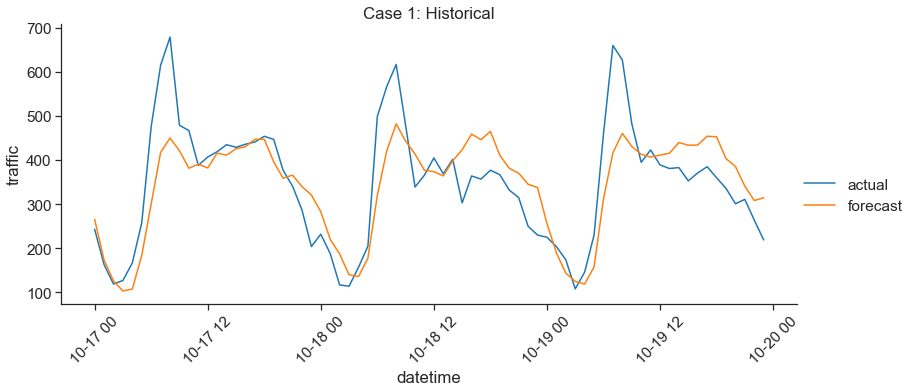

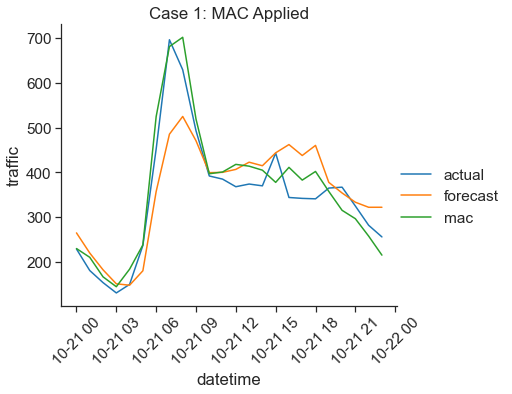

In [8]:
outputs = train_test("2016-10-15", "2016-10-17", "2016-10-19") # Generate "historical" forecast (3 periods)
outputs_future = train_test("2016-10-19", "2016-10-21", "2016-10-21") # Generate "future" forecast (1 period)

# Broadway Southbound from west 174 street to west 175 street
mk_timeplot(outputs, 'images/case1_historical.png', 'Case 1: Historical')
mk_timeplot(apply_mac(outputs, outputs_future), "images/case1_future.png", 'Case 1: MAC Applied', 1.2)


e:\programming\iso\nyc\env\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
e:\programming\iso\nyc\env\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Historical Forecast Error: 43.711855928651296
Future Forecast Error: 54.71670855482315
MAC Future Forecast Error: 58.40060469039715


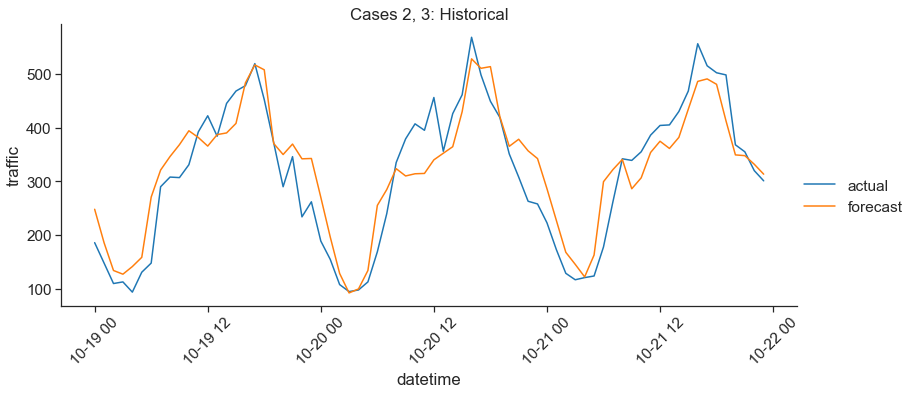

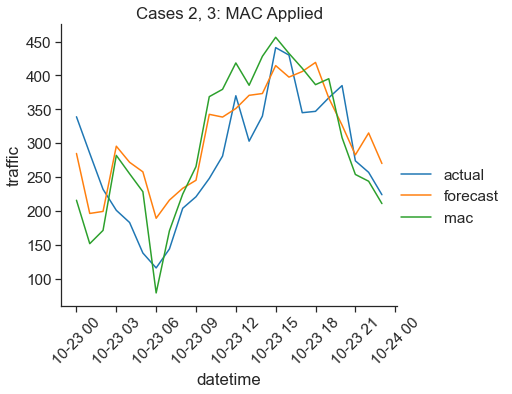

In [10]:
# Note: changed x_test = x_test[x_test.Direction == 1] in train_test to switch from southbound to northbound
outputs = train_test("2016-10-15", "2016-10-19", "2016-10-21")
outputs_future = train_test("2016-10-21", "2016-10-23", "2016-10-23")

# Broadway Northbound from west 174 street to west 175 street
mk_timeplot(outputs, 'images/case3_historical.png', 'Cases 2, 3: Historical')
mk_timeplot(apply_mac(outputs, outputs_future), "images/case3_future.png", 'Cases 2, 3: MAC Applied', 1.2)